<h2> Projet Seattle

In [92]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


In [93]:
#filepath_X = '/home/et/Mytest/my_py3/02_Seattle/Xs.csv'
#filepath_Y = '/home/et/Mytest/my_py3/02_Seattle/Ys.csv'

#filepath_X = '/Users/efkanturedi/Corteze/my_py3/02_Seattle/Xs.csv'
#filepath_Y = '/Users/efkanturedi/Corteze/my_py3/02_Seattle/Ys.csv'

filepath_X = '/Users/efkanturedi/Corteze/my_py3/02_Seattle/Xs_no_es.csv'
filepath_Y = '/Users/efkanturedi/Corteze/my_py3/02_Seattle/Ys_no_es.csv'

#filepath_X = '/home/efkant/Corteze/my_py3/02_Seattle/Xs.csv'
#filepath_Y = '/home/efkant/Corteze/my_py3/02_Seattle/Ys.csv'

#filepath_X = '/home/efkant/Corteze/my_py3/02_Seattle/Xs_no_es.csv'
#filepath_Y = '/home/efkant/Corteze/my_py3/02_Seattle/Ys_no_es.csv'


In [94]:
X = pd.read_csv(filepath_X)
Y = pd.read_csv(filepath_Y)

In [95]:
from sklearn import model_selection
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y['log-SiteEnergyUseWN(kBtu)'],test_size=0.3) # 30% des données dans le jeu de test

In [96]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(Y_train.isna().sum().sum())
print(Y_test.isna().sum().sum())

0
0
0
0


<h1>MACHINE LEARNING 

In [97]:
import math
from sklearn.metrics import mean_squared_error

In [98]:
from sklearn.dummy import DummyRegressor
import numpy as np

# On crée un modèle qui renvoie constamment la moyenne des données selectionnées
dummy_reg = DummyRegressor(strategy="mean")

# On entraîne ce modèle sur les données d'entrainement
dummy_reg.fit(X_train,Y_train)

results = pd.DataFrame(columns=['Modèle','RMSE','RMSE_rel','Inference_duration (microsecs)'])

start_time = datetime.now()
test = mean_squared_error(dummy_reg.predict(X_test), Y_test)
end_time = datetime.now()
dummy_time = end_time - start_time


ref = mean_squared_error(dummy_reg.predict(X_test), Y_test)
rmse_ref = math.sqrt(ref)

rmse_estimator_dummy = math.sqrt(test)
rmse_rel_dummy = abs((rmse_estimator_dummy - rmse_ref))/rmse_ref
percentage_rmse_rel_dummy = "{:.2%}".format(rmse_rel_dummy)

#just for this case, test == ref

results = results.append({
    'Modèle' : 'Dummy Regressor',
    'RMSE' : rmse_estimator_dummy,
    'RMSE_rel' : percentage_rmse_rel_dummy,
    'Inference_duration (microsecs)': dummy_time.microseconds
    }
    ,ignore_index=True)


In [99]:
results

,Modèle,RMSE,RMSE_rel,Inference_duration (microsecs)
0,Dummy Regressor,1.427288,0.00%,403


In [100]:
from sklearn.model_selection import GridSearchCV

In [101]:
from sklearn.linear_model import ElasticNet

#Fonction Coût Elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

#Si alpha = 0, ceci est un OLS classique

parameters = {'tol' : [0.1,0.01,0.001,0.0001], 
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha est le coefficient qui multiplie le terme de pénalité. Alpha = 1.0 par défaut
              "l1_ratio": np.arange(0.0, 1.0, 0.1)} #L1 ratio ,0: Ridge; 1:Lasso


elastic_net = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      cv=5,
                      verbose=False
                     )

elastic_net.fit(X_train, Y_train);

/Users/efkanturedi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1320.4756029725545, tolerance: 489.7589110192446
  model = cd_fast.enet_coordinate_descent(
/Users/efkanturedi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1881.3357131975179, tolerance: 572.878307472136
  model = cd_fast.enet_coordinate_descent(
/Users/efkanturedi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1676.3503926790581, tolerance: 549.4156594970569
  model = cd_fast.enet_coordinate_descent(
/Users/efkanturedi/opt/

In [102]:
elastic_net.best_params_

{'alpha': 0.01, 'l1_ratio': 0.0, 'tol': 0.1}

In [103]:
import math
start_time = datetime.now()
test = mean_squared_error(elastic_net.predict(X_test), Y_test)
end_time = datetime.now()

elasticnet_time = end_time-start_time

rmse_estimator_elasticnet = math.sqrt(test)
rmse_rel_elasticnet = abs((rmse_estimator_elasticnet - rmse_ref))/rmse_ref
percentage_rmse_rel_elasticnet = "{:.2%}".format(rmse_rel_elasticnet)

results = results.append({
    'Modèle' : 'Elasticnet',
    'RMSE' : rmse_estimator_elasticnet,
    'RMSE_rel' : percentage_rmse_rel_elasticnet,
    'Inference_duration (microsecs)': elasticnet_time.microseconds
    }
    ,ignore_index=True)

In [104]:
results

,Modèle,RMSE,RMSE_rel,Inference_duration (microsecs)
0,Dummy Regressor,1.427288,0.00%,403
1,Elasticnet,1.138766,20.21%,2672


RANDOM FOREST


In [105]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators' : [10,50,100,300,500],
    'min_samples_leaf' : [1,3,5,10], 
    'max_features': ['auto', 'sqrt']
}

In [106]:

rfr = GridSearchCV(RandomForestRegressor(),
                              param_grid = parameters,
                              verbose=False,
                              cv=5)

rfr.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=False)

In [107]:
rfr.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

In [108]:
start_time = datetime.now()
test = mean_squared_error(rfr.predict(X_test), Y_test)
end_time = datetime.now()
rfr_time = end_time - start_time

rmse_estimator_rfr = math.sqrt(test)
rmse_rel_rfr = abs((rmse_estimator_rfr - rmse_ref))/rmse_ref
percentage_rmse_rel_rfr = "{:.2%}".format(rmse_rel_rfr)

results = results.append({
    'Modèle' : 'Random Forest',
    'RMSE' : rmse_estimator_rfr,
    'RMSE_rel' : percentage_rmse_rel_rfr,
    'Inference_duration (microsecs)': rfr_time.microseconds
    }
    ,ignore_index=True)

In [109]:
results

,Modèle,RMSE,RMSE_rel,Inference_duration (microsecs)
0,Dummy Regressor,1.427288,0.00%,403
1,Elasticnet,1.138766,20.21%,2672
2,Random Forest,1.030050,27.83%,81091


In [110]:
coefficients = abs(rfr.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variables']), 
                      pd.DataFrame(coefficients, columns = ['Coefficients'])), axis = 1).sort_values(by='Coefficients', ascending = False)

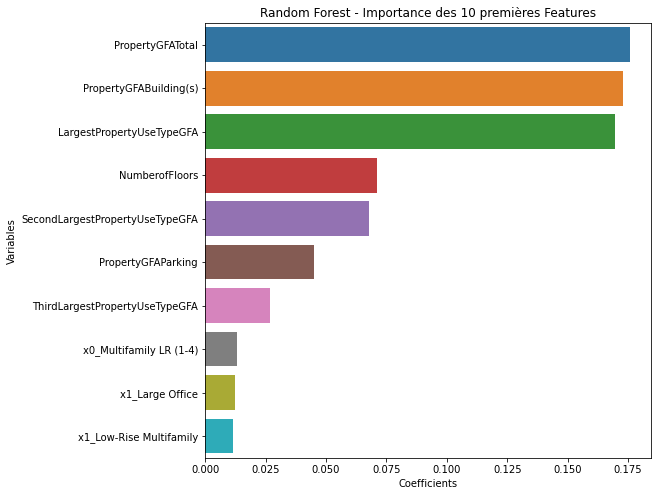

In [111]:
plt.figure(figsize=(8,8))
plt.title('Random Forest - Importance des 10 premières Features')
sns.barplot(y = liste_coefs_rer['Variables'].head(10),
            x = liste_coefs_rer['Coefficients'].head(10))
plt.show()

SVM

In [112]:
from sklearn.svm import SVR

parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #Kernel par defaut RBF
              'epsilon' : [0.001, 0.01, 0.1, 1], #tolérance par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #Régularisation

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      cv=5,
                      verbose=False
                     )

svm.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             verbose=False)

In [113]:
svm.best_params_

{'C': 1, 'epsilon': 0.1, 'gamma': 0.1}

In [114]:
start_time = datetime.now()
test = mean_squared_error(svm.predict(X_test), Y_test)
end_time = datetime.now()
svm_time = end_time - start_time

rmse_estimator_svm = math.sqrt(test)
rmse_rel_svm = abs((rmse_estimator_svm - rmse_ref))/rmse_ref
percentage_rmse_rel_svm = "{:.2%}".format(rmse_rel_svm)

results = results.append({
    'Modèle' : 'SVM',
    'RMSE' : rmse_estimator_svm,
    'RMSE_rel' : percentage_rmse_rel_svm,
    'Inference_duration (microsecs)': svm_time.microseconds
    }
    ,ignore_index=True)


In [115]:
results

,Modèle,RMSE,RMSE_rel,Inference_duration (microsecs)
0,Dummy Regressor,1.427288,0.00%,403
1,Elasticnet,1.138766,20.21%,2672
2,Random Forest,1.030050,27.83%,81091
3,SVM,0.998682,30.03%,580638


In [116]:
from xgboost import XGBRegressor

In [117]:
parameters = {
    'n_estimators' : [10,20,50,100,500,1000,2000]
}
xgb = GridSearchCV(XGBRegressor(),
                        param_grid = parameters,
                        cv = 5,
                        verbose=False)
xgb.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [118]:
xgb.best_params_

{'n_estimators': 20}

In [119]:
start_time = datetime.now()
test = mean_squared_error(xgb.predict(X_test), Y_test)
end_time = datetime.now()
xgb_time = end_time - start_time

rmse_estimator_xgb = math.sqrt(test)
rmse_rel_xgb = abs((rmse_estimator_xgb - rmse_ref))/rmse_ref
percentage_rmse_rel_xgb = "{:.2%}".format(rmse_rel_xgb)

results = results.append({
    'Modèle' : 'XGBoost',
    'RMSE' : rmse_estimator_xgb,
    'RMSE_rel' : percentage_rmse_rel_xgb,
    'Inference_duration (microsecs)': xgb_time.microseconds
    }
    ,ignore_index=True)

In [120]:
results

,Modèle,RMSE,RMSE_rel,Inference_duration (microsecs)
0,Dummy Regressor,1.427288,0.00%,403
1,Elasticnet,1.138766,20.21%,2672
2,Random Forest,1.030050,27.83%,81091
3,SVM,0.998682,30.03%,580638
4,XGBoost,1.152892,19.22%,5655
